## ESAT Uncertainty Perturbation Workflow

This notebook implements an uncertainty perturbation workflow for model evaluation.

Here the Factor Catalog is derived by evaluating the correlation between factor Ws.

#### Code Imports

In [1]:
import time
import copy

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from tqdm.notebook import trange, tqdm, tnrange
from plotly.subplots import make_subplots
from esat.data.datahandler import DataHandler
from esat.model.sa import SA
from esat.model.batch_sa import BatchSA
from esat.data.analysis import ModelAnalysis, BatchAnalysis
from esat.error.bootstrap import Bootstrap
from esat_eval.simulator import Simulator
from esat_eval.factor_comparison import FactorCompare

pd.options.display.float_format = '{:.4f}'.format

In [2]:
# Synethic dataset parameter value ranges
syn_factors_min = 3
syn_factors_max = 8

syn_features_min = 15
syn_features_max = 45

syn_samples_min = 200
syn_samples_max = 1000

outliers = True
outliers_p_min = 0.05
outliers_p_max = 0.1
outliers_mag_min = 1.1
outliers_mag_max = 2

noise_mean_min = 0.05
noise_mean_max = 0.15
noise_scale = 0.01

uncertainty_mean_min = 0.05
uncertainty_mean_max = 0.15
uncertainty_scale = 0.01

contr_curve_min_range = [0.0, 1.0]
contr_curve_max_range = [2.0, 5.0]
contr_curve_scale_range = [0.1, 0.5]

random_seed = 337
k_coef = 0.75

In [3]:
rng = np.random.default_rng(seed=random_seed)

In [4]:
# Initialize the simulator with the above parameters
def generate_synthetic_data(true_factor):
    n_features = rng.integers(low=syn_features_min, high=syn_features_max, size=1)[0]
    n_samples = rng.integers(low=syn_samples_min, high=syn_samples_max, size=1)[0]
    i_outlier_p = round(rng.uniform(low=outliers_p_min, high=outliers_p_max, size=1)[0], 2)
    i_outlier_mag = round(rng.uniform(low=outliers_mag_min, high=outliers_mag_max, size=1)[0], 2)
    contribution_max = round(rng.uniform(low=1.0, high=10.0, size=1)[0], 2)
    print(f"True Factors: {true_factor}, Features: {n_features}, Samples: {n_samples}, Outliers %: {i_outlier_p}, Outliers Magnitude: {i_outlier_mag}, Contribution Max: {contribution_max}")
    simulator = Simulator(seed=rng.integers(low=0, high=10, size=1)[0],
                          factors_n=true_factor,
                          features_n=n_features,
                          samples_n=n_samples,
                          outliers=outliers,
                          outlier_p=i_outlier_p,
                          outlier_mag=i_outlier_mag,
                          contribution_max=contribution_max,
                          noise_mean_min=noise_mean_min,
                          noise_mean_max=noise_mean_max,
                          noise_scale=noise_scale,
                          uncertainty_mean_min=uncertainty_mean_min,
                          uncertainty_mean_max=uncertainty_mean_max,
                          uncertainty_scale=uncertainty_scale,
                          verbose=False
                         )
    curved_factors_count = rng.integers(low=0, high=true_factor, size=1)[0]
    curved_factor_list = rng.choice(list(range(true_factor)), size=curved_factors_count, replace=False)
    for c_i in curved_factor_list:
        # parameters not used by the curve type are ignored
        i_curve_type = rng.choice(['uniform', 'decreasing', 'increasing', 'logistic', 'periodic'], size=1)[0]
        i_curve_min = rng.uniform(low=contr_curve_min_range[0], high=contr_curve_min_range[1], size=1)[0]
        i_curve_max = rng.uniform(low=contr_curve_max_range[0], high=contr_curve_max_range[1], size=1)[0]
        i_curve_scale = rng.uniform(low=contr_curve_scale_range[0], high=contr_curve_scale_range[1], size=1)[0]
        i_curve_frequency = rng.uniform(low=0.1, high=0.9, size=1)[0]
        
        # To keep all as uniform comment out the line below
        # simulator.update_contribution(factor_i=c_i, curve_type=i_curve_type, scale=i_curve_scale, frequency=i_curve_frequency, minimum=i_curve_min, maximum=i_curve_max)
    
    syn_input_df, syn_uncertainty_df = simulator.get_data()
    data_handler = DataHandler.load_dataframe(input_df=syn_input_df, uncertainty_df=syn_uncertainty_df)
    data_handler.metrics
    V, U = data_handler.get_data()
    return V, U

def perturb_uncertainty(u, _rng, perturb_p = 0.25, sigma = 0.25):
    i_u = copy.copy(u)
    if isinstance(perturb_p, float):
        perturb_p = [perturb_p for i in range(u.shape[1])]
    elif isinstance(perturb_p, list) and len(perturb_p) != u.shape[1]:
        perturb_p = [perturb_p[0] for i in range(u.shape[1])]
    if isinstance(sigma, float):
        sigma = [sigma for i in range(u.shape[1])]
    elif isinstance(sigma, list) and len(sigma) != u.shape[1]:
        sigma = [sigma[0] for i in range(u.shape[1])]
    for i, _p in enumerate(perturb_p):
        i_mask = _rng.random(size=u[:,i].shape) > _p
        i_mean = 0.0
        i_logn = _rng.lognormal(i_mean, sigma[i], size=u[:,i].shape)
        ij_u = i_u[:,i]
        ij_u = ij_u * i_logn
        ij_u[i_mask] = ij_u[i_mask]
        ij_u[ij_u <= 0.0] = 1e-12
        i_u[:,i] = ij_u
    return i_u


def run_perturbation(v, u, factors, random_seed, u_collection = None, perturb_p = 1.0, sigma = 0.33, sa_model=None, models=10, max_iter=10000, converge_n=50, converge_delta=0.01, threshold: float=0.9, pg_leave=True, verbose=False):
    # Runs a perturbation input batch instance
    # Steps:
    # 1. Create a SA instance using the provided iV, iU and true_k for the data and factor count (if one is not provided).
    # 2. Using a lognormal std (sigma) and % instance change (perturb_p) for the uncertainty:
    #    a. Select perturb_p number of indecies from the uncertainty data matrix and change those values by a random selection from a lognormal distribution with mean=1 and sigma/std=the provided valude (default=0.25)
    #    b. Use a provided collection of pre-defiend uncertainty matrices
    # 3. With the perturbed uncertainty rerun the model using the base model H matrix.
    # 4. Repeat for n number of models
    # 5. Evaluate the results from all the perturb model profiles and concentrations, the ones that mapped (had a correlation above the threhsold) and provide the range of values for the factors.
    rng = np.random.default_rng(seed=random_seed)
    # step 1
    if sa_model is None:
        sa_model = SA(V=v, U=u, factors=factors, seed=random_seed, verbose=verbose, method="ls-nmf")
        sa_model.initialize()
        sa_model.train(max_iter=max_iter, converge_delta=converge_delta, converge_n=converge_n)

    base_mean_W = np.mean(sa_model.W, axis=0)[0]
    base_mass_matrix = (base_mean_W*sa_model.H)/np.sum(base_mean_W*sa_model.H)    # base mass matrix
    
    perturb_results = {
        "k": factors,
        "seed": random_seed,
        "base model": sa_model,
        "perturb %": perturb_p,
        "perturb sigma": sigma,
        "perturb results": {}
    }
    
    for i in tnrange(models, desc="Running Perturbations on base model", leave=pg_leave):
        if u_collection is None:
            i_u = perturb_uncertainty(u=u, perturb_p=perturb_p, sigma=sigma, _rng=rng)
        elif i > len(u_collection):
            i_u = perturb_uncertainty(u=u, perturb_p=perturb_p, sigma=sigma, _rng=rng)
        else:
            i_u = u_collection[i]
            
        i_sa_model = SA(v, U=i_u, factors=factors, seed=random_seed, verbose=verbose, method="ls-nmf")
        i_sa_model.initialize(H=sa_model.H, W=sa_model.W)
        i_sa_model.train(max_iter=max_iter, converge_delta=converge_delta, converge_n=converge_n)

        i_results = {
            "model": copy.copy(i_sa_model),
            "corr": [],
            "corr_mapping": [],
            "all_corr": [],
            "raae": [],
            "raae_mapping": [],
            "all_raae": [],
            "emc": [],
            "emc_mapping": [],
            "all_emc": []
        }
        n = 1/sa_model.W[:,0].shape[0]

        i_W_mean = np.mean(i_sa_model.W, axis=0)[0]
        i_mass_matrix = (i_W_mean*i_sa_model.H)/np.sum(i_W_mean*i_sa_model.H)   # perturbed mass matrix
        
        for j in range(factors):
            j_W = sa_model.W[:,j]      # Base model W column j (factor contribution)
            j_H = sa_model.H[j]        # Base model H row j (factor profile)

            # Tacking results of equation 4
            j_r2 = 0.0
            r2_best = -1
            all_corr = []

            # Tracking results of equation 5
            j_raae = float("inf")
            raae_best = -1
            all_raae = []

            # Tracking results of equation 7
            j_emc = 0.0
            best_emc = -1
            all_emc = []
            
            for k in range(factors):
                k_W = i_sa_model.W[:,k]    # Perturbed model i, W column j (perturbed factor contribution j)
                jk_r2 = FactorCompare.calculate_correlation(factor1=j_W.flatten(), factor2=k_W.flatten())    # Equation 4
                jk_raae = (np.sum(np.abs(k_W - j_W))*n)/(np.sum(j_W)*n)                                      # Equation 5
                jk_emc = FactorCompare.calculate_correlation(factor1=base_mass_matrix[j], factor2= i_mass_matrix[k]) # Equation 7
                
                if jk_r2 > j_r2:
                    r2_best = k 
                    j_r2 = jk_r2
                if jk_raae < j_raae:
                    j_raae = jk_raae
                    raae_best = k
                if jk_emc > j_emc:
                    j_emc = jk_emc
                    best_emc = k
                all_corr.append(jk_r2)
                all_raae.append(jk_raae)
                all_emc.append(jk_emc)
            i_results["corr"].append(j_r2)
            i_results["corr_mapping"].append(r2_best)
            i_results["all_corr"].append(all_corr)
            i_results["raae"].append(j_raae)
            i_results["raae_mapping"].append(raae_best)
            i_results["all_raae"].append(all_raae)
            i_results["emc"].append(j_emc)
            i_results["emc_mapping"].append(best_emc)
            i_results["all_emc"].append(all_emc)
        perturb_results["perturb results"][i] = i_results
    return perturb_results
    

## Single Perturbation Instance

A single instance of the run_perturbation function is called. This will create a single SA instance to use as the base model with n_models being the number of perturbed instances to make (each independent of each other) for that single base model.

In [5]:
%%time
true_k = 6
iV, iU = generate_synthetic_data(true_factor=true_k)

True Factors: 6, Features: 24, Samples: 222, Outliers %: 0.06, Outliers Magnitude: 1.8, Contribution Max: 9.26
CPU times: total: 62.5 ms
Wall time: 77.7 ms


In [7]:
estimate_k = 6
n_models = 10
threshold = 0.9

perturb_p = 1.0
perturb_sigma = 0.25

batch_results0 = run_perturbation(factors=estimate_k, v=iV, u=iU, random_seed=random_seed, perturb_p=perturb_p, sigma=perturb_sigma, models=n_models, max_iter=20000, converge_n=20, converge_delta=0.01, threshold=threshold)

Running Perturbations on base model:   0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
# Metrics
# Factor mapping (what percentage of perturbed model factors map to the base model factors, using corr(W), RAAE or EMC)
# Factor profile ranges (among mapped perturbed model factors)
# Factor mean contribution ranges (among mapped pertrubed model factors)
n_factors = estimate_k
corr_mapping = [0] * n_factors
raae_mapping = [0] * n_factors
emc_mapping = [0] * n_factors
for i, p_model in batch_results0["perturb results"].items():
    cmap_dif = np.subtract(p_model["corr_mapping"], list(range(n_factors)))
    raae_dif = np.subtract(p_model["raae_mapping"], list(range(n_factors)))
    emc_dif = np.subtract(p_model["emc_mapping"], list(range(n_factors)))
    for j in range(n_factors):
        if cmap_dif[j] == 0:
            corr_mapping[j] += 1
        if raae_dif[j] == 0:
            raae_mapping[j] += 1
        if emc_dif[j] == 0:
            emc_mapping[j] += 1
mapping_df = pd.DataFrame(data=
                          {
                              "Factor": list(range(n_factors)), 
                              "R2": np.round(100 * np.array(corr_mapping)/n_models, 2), 
                              "RAAE": np.round(100 * np.array(raae_mapping)/n_models, 2), 
                              "EMC": np.round(100 * np.array(emc_mapping)/n_models, 2)
                          }
                         )
mapping_df

,Factor,R2,RAAE,EMC
0,0,100.0000,100.0000,100.0000
1,1,100.0000,100.0000,100.0000
2,2,100.0000,100.0000,100.0000
3,3,100.0000,100.0000,100.0000
4,4,100.0000,100.0000,100.0000
5,5,100.0000,100.0000,100.0000


In [9]:
df_columns = [f"Factor {i}" for i in range(n_factors)]
df_index = [f"Base Factor {i}" for i in range(n_factors)]
corr_df = pd.DataFrame(data=np.array(batch_results0["perturb results"][0]["all_corr"]), columns=df_columns, index=df_index)
print("Correlation Matrix")
corr_df

Correlation Matrix


,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Base Factor 0,0.9842,0.0189,0.0000,0.0199,0.0018,0.0083
Base Factor 1,0.0182,0.9945,0.0035,0.0008,0.0041,0.0000
Base Factor 2,0.0006,0.0009,0.9848,0.0004,0.0039,0.0099
Base Factor 3,0.0088,0.0007,0.0029,0.9886,0.0051,0.0049
Base Factor 4,0.0185,0.0000,0.0166,0.0144,0.9514,0.0025
Base Factor 5,0.0082,0.0000,0.0113,0.0045,0.0081,0.9960


In [10]:
raae_df = pd.DataFrame(data=np.array(batch_results0["perturb results"][0]["all_raae"]), columns=df_columns, index=df_index)
print("RAAE Matrix")
raae_df

RAAE Matrix


,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Base Factor 0,0.0495,1.2054,1.0972,1.0375,0.6664,1.7512
Base Factor 1,0.6353,0.0307,0.6976,0.6547,0.6858,0.8460
Base Factor 2,0.6322,0.7401,0.0504,0.6565,0.6765,0.8810
Base Factor 3,0.6450,0.7910,0.7467,0.0451,0.6558,0.9785
Base Factor 4,0.8291,1.5773,1.3635,1.2182,0.1085,2.1753
Base Factor 5,0.7095,0.6458,0.6191,0.6193,0.7406,0.0247


In [11]:
emc_df = pd.DataFrame(data=np.array(batch_results0["perturb results"][1]["all_emc"]), columns=df_columns, index=df_index)
print("EMC Matrix")
emc_df

EMC Matrix


,Factor 0,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Base Factor 0,0.9980,0.0893,0.0687,0.0001,0.0404,0.0024
Base Factor 1,0.0843,0.9977,0.0488,0.0174,0.0045,0.0583
Base Factor 2,0.0876,0.0594,0.9971,0.1261,0.1389,0.0016
Base Factor 3,0.0005,0.0147,0.1238,0.9987,0.0218,0.0077
Base Factor 4,0.0245,0.0030,0.1889,0.0406,0.9944,0.0084
Base Factor 5,0.0076,0.0631,0.0020,0.0059,0.0051,0.9984


In [12]:
mean_emc = np.mean(np.diagonal(emc_df.values))
mean_emc

0.9973782987861816

In [13]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import min_weight_full_bipartite_matching

# Optimized Factor Search Algorithm
# Step 1: check indices of max/min values (corr,emc/raae) by column. If all are unique this is the optimal mapping.
# Step 2: perform a min weight full bipartite matching, where each column index is mapped to a row index to maximize or minimize the sum of matching.

def optimal_mapping_algorithm(batch_results, mapping_type: str = "raae"):
    n_factors = batch_results["k"]
    batch_mapping = {}
    batch_values = {}
    for i, p_model in batch_results["perturb results"].items():
        model_mapping = None
        mapping_values = [-1 for i in range(n_factors)]
        mapping_matrix = None
        if mapping_type == "raae":
            optimal_indices = np.array(p_model["all_raae"]).argmin(axis=0)
            mapping_matrix = np.array(p_model["all_raae"])
            maximize = False
        elif mapping_type == "emc":
            optimal_indices = np.array(p_model["all_emc"]).argmax(axis=0)
            mapping_matrix = np.array(p_model["all_emc"])
            maximize = True
        else:
            optimal_indices = np.array(p_model["all_corr"]).argmax(axis=0)
            mapping_matrix = np.array(p_model["all_corr"])
            maximize = True

        # Step 1, all optimal value indices are unique and no other values need to be checked.
        if (np.unique(optimal_indices, return_counts=True)[1].max() == 1):
            model_mapping = optimal_indices
        else:
            m_bi_matrix = csr_matrix(mapping_matrix)
            model_mapping = list(min_weight_full_bipartite_matching(m_bi_matrix, maximize=maximize))
        optimal_index_tuples = list(zip(list(range(n_factors)), model_mapping))
        for j, oi in enumerate(optimal_index_tuples):
            ele_values = mapping_matrix[oi]
            mapping_values[j] = np.round(ele_values, 4)
        
        batch_mapping[i] = optimal_indices
        batch_values[i] = mapping_values
        
    return batch_mapping, batch_values

In [14]:
mapping_results = optimal_mapping_algorithm(batch_results=batch_results0, mapping_type="emc")
mapping_results

({0: array([0, 1, 2, 3, 4, 5], dtype=int64),
  1: array([0, 1, 2, 3, 4, 5], dtype=int64),
  2: array([0, 1, 2, 3, 4, 5], dtype=int64),
  3: array([0, 1, 2, 3, 4, 5], dtype=int64),
  4: array([0, 1, 2, 3, 4, 5], dtype=int64),
  5: array([0, 1, 2, 3, 4, 5], dtype=int64),
  6: array([0, 1, 2, 3, 4, 5], dtype=int64),
  7: array([0, 1, 2, 3, 4, 5], dtype=int64),
  8: array([0, 1, 2, 3, 4, 5], dtype=int64),
  9: array([0, 1, 2, 3, 4, 5], dtype=int64)},
 {0: [0.9983, 0.9934, 0.999, 0.9984, 0.9891, 0.9983],
  1: [0.998, 0.9977, 0.9971, 0.9987, 0.9944, 0.9984],
  2: [0.9959, 0.9989, 0.9988, 0.9987, 0.9872, 0.9992],
  3: [0.9994, 0.9968, 0.9981, 0.9995, 0.9951, 0.9982],
  4: [0.9984, 0.9943, 0.9985, 0.9958, 0.989, 0.9988],
  5: [0.9979, 0.9976, 0.9982, 0.9981, 0.9923, 0.9991],
  6: [0.9992, 0.9913, 0.9985, 0.9989, 0.9954, 0.9986],
  7: [0.9977, 0.9971, 0.9977, 0.9984, 0.9952, 0.9992],
  8: [0.9985, 0.9968, 0.9979, 0.9981, 0.9867, 0.9985],
  9: [0.9976, 0.9956, 0.9967, 0.9988, 0.994, 0.9991]})

In [15]:
threshold_map = np.array(mapping_results[1][0]) > 0.95
threshold_map

array([ True,  True,  True,  True,  True,  True])

In [17]:
base_H = batch_results0["base model"].H
base_H = (base_H / np.sum(base_H, axis=0))
threshold = 0.95

p_Hs = []
p_Qs = []
for p, p_results in batch_results0["perturb results"].items():
    p_model = p_results["model"]
    p_H = (p_model.H / np.sum(p_model.H, axis=0))
    _p_H = []
    p_mapping = mapping_results[0][p]
    p_map_metric = np.array(mapping_results[1][p]) > threshold
    for i in range(p_model.factors):
        if p_map_metric[i]:
            _p_H.append(p_H[p_mapping[i]])
        else:
            _p_H.append(base_H[p_mapping[i]])
    _p_H = np.array(_p_H)
    p_Hs.append(_p_H)
    p_Qs.append(p_model.Qtrue)
perturb_H = np.dstack(p_Hs)
mean_perturb_H = np.mean(perturb_H, axis=2)
std_perturb_H = np.std(perturb_H, axis=2)
min_perturb_H = np.min(perturb_H, axis=2)
max_perturb_H = np.max(perturb_H, axis=2)

feature_labels = [f"Feature {i+1}" for i in range(base_H.shape[1])]
print(f"QTrue - Base: {np.round(batch_results0["base model"].Qtrue,4)}, Perturb Mean: {np.round(np.mean(p_Qs),4)}, Perturb STD: {np.round(np.std(p_Qs),4)}, Perturb Min: {np.round(np.min(p_Qs),4)}, Perturb Max: {np.round(np.max(p_Qs),4)}")

QTrue - Base: 13351.1866, Perturb Mean: 14053.3762, Perturb STD: 250.7151, Perturb Min: 13665.559, Perturb Max: 14523.8171


In [17]:
factor_i = 1
f1_dict = {
    "Base": base_H[factor_i],
    "Mean Perturb": mean_perturb_H[factor_i],
    "% diff": np.round(100*(mean_perturb_H[factor_i] - base_H[factor_i])/((mean_perturb_H[factor_i] + base_H[factor_i])/2) , 4),
    "STD Perturb": std_perturb_H[factor_i],
    "Min Perturb": min_perturb_H[factor_i],
    "Max Perturb": max_perturb_H[factor_i],
}
f1_dict["% diff"][f1_dict["Mean Perturb"] < 1e-6] = 0.0 

f1_df = pd.DataFrame(f1_dict, index=feature_labels).round(10)
f1_df

,Base,Mean Perturb,% diff,STD Perturb,Min Perturb,Max Perturb
Feature 1,0.1555,0.1547,-0.5557,0.0463,0.0827,0.2464
Feature 2,0.0368,0.0474,25.1585,0.0301,0.0000,0.0824
Feature 3,0.0302,0.0274,-9.6511,0.0352,0.0000,0.0943
Feature 4,0.4084,0.3936,-3.6823,0.0310,0.3436,0.4516
Feature 5,0.2568,0.2600,1.2598,0.0362,0.2134,0.3409
Feature 6,0.4090,0.4002,-2.1716,0.0291,0.3644,0.4573
Feature 7,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Feature 8,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Feature 9,0.3007,0.3021,0.4614,0.0469,0.2068,0.3894
Feature 10,0.2439,0.2319,-5.0589,0.0435,0.1646,0.2857


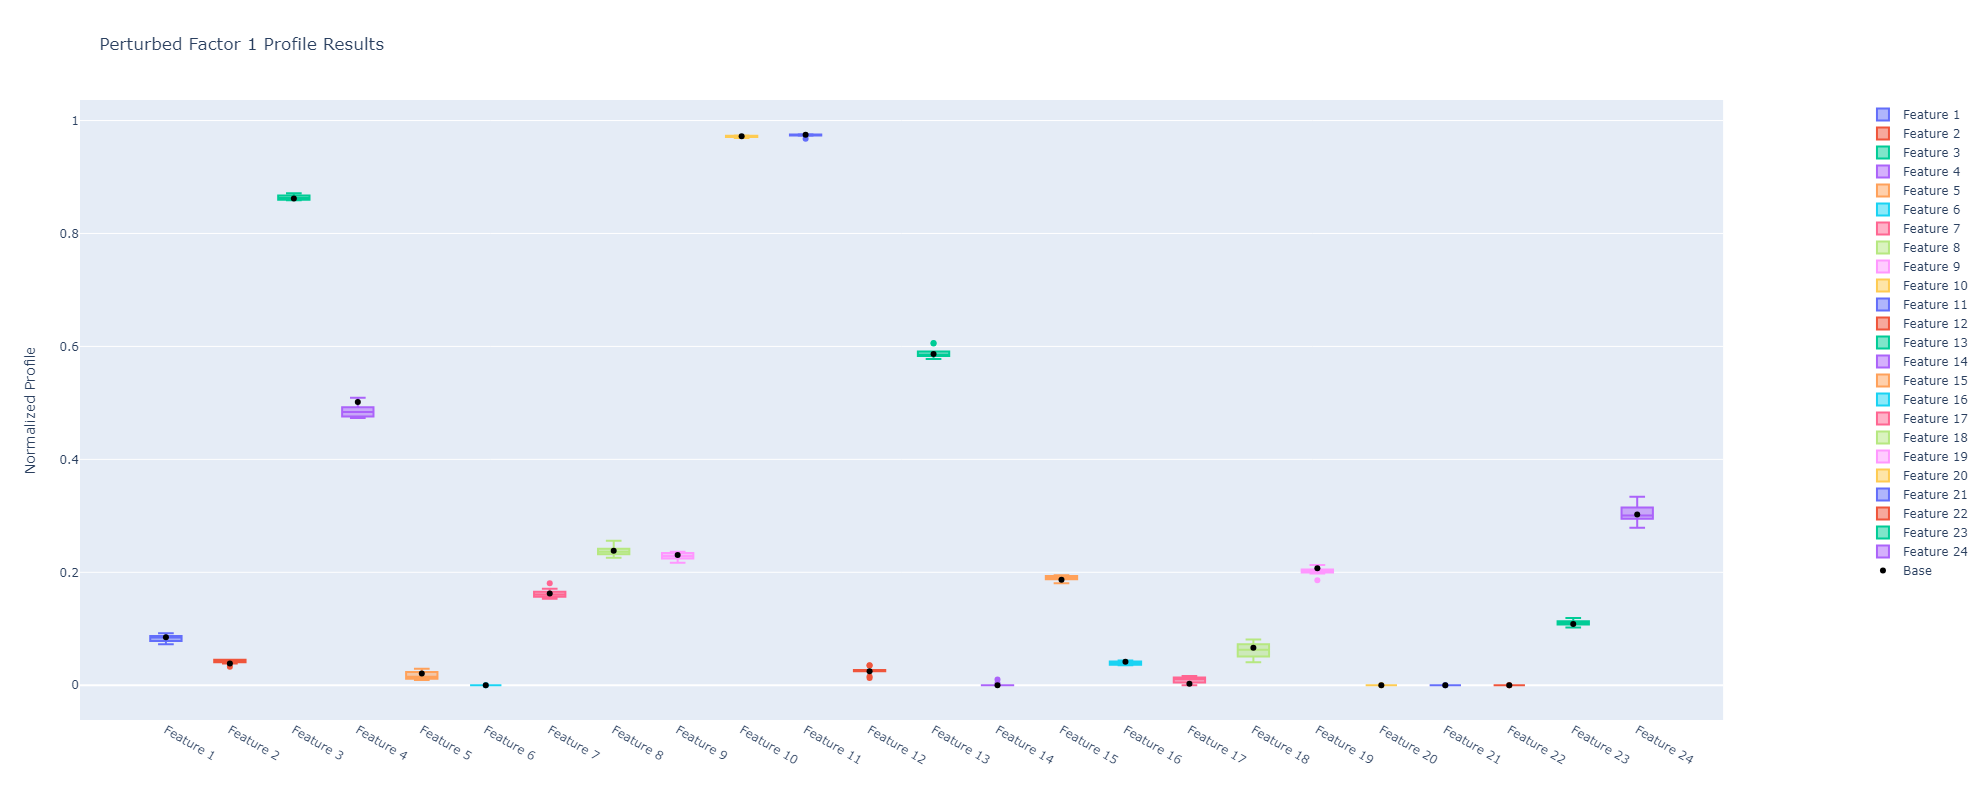

In [20]:
factor_i = 1
factor_p0_fig = make_subplots(specs=[[{"secondary_y": True}]])
for i in range(len(feature_labels)):
    f_feature_i = perturb_H[factor_i,i]
    factor_p0_fig.add_trace(go.Box(y=f_feature_i, name=feature_labels[i]), secondary_y=False)
factor_p0_fig.add_trace(go.Scatter(x=feature_labels, y=base_H[factor_i], name="Base", mode="markers", marker_color="black"), secondary_y=False)
factor_p0_fig.update_layout(title=f"Perturbed Factor {factor_i} Profile Results", width=1200, height=800, hovermode='x unified')
factor_p0_fig.update_yaxes(title_text="Normalized Profile", secondary_y=False)
factor_p0_fig.show()

## Batch Perturbation Instance

Run multiple single perturbation instances, creating a collection of base models and their corresponding perturbed models. Create a dictionary of factor profiles, linking them to a model and factor profile by correlation mapping (above a specified threshold).

Aggregated results will include:
1. A list of factor profiles and their % occurrence across all base models
2. The base models which include the highest % occuring factor profiles
3. The factor profile ranges across the perturbed models sharing those factor profiles.

In [ ]:
def run_batch_perturbation(factors, v, u, random_seed, v_collection=None, batches=10, perturb_p=0.5, perturb_v=0.05, models=100, max_iter=20000, converge_n=20, converge_delta=0.01, threshold=0.9):
    batch_collections = []
    for b in trange(batches, desc='Running Perturbation Instances'):
        b_seed = rng.integers(low=1, high=1e10)
        batch_results = run_perturbation(factors=factors, v=v, u=u, random_seed=b_seed, v_collection=v_collection, perturb_p=perturb_p, perturb_v=perturb_v, models=n_models, max_iter=max_iter, converge_n=converge_n, converge_delta=converge_delta, threshold=threshold, pg_leave=False)
        batch_collections.append(batch_results)
    return batch_collections

def check_factor_catalog_V(factor_V, factor_catalog):
    best_r2 = 0.0
    mapped_k = -1
    for factor_i, factor_details in factor_catalog.items():
        vk_r2_list = []
        for f_Vk in factor_details["Vk"]:
            with np.errstate(divide='ignore', invalid='ignore'):
                vk_r2 = FactorCompare.calculate_correlation(f_Vk.flatten(), factor_V.flatten())
            vk_r2_list.append(vk_r2)
        vk_r2_mean = np.mean(vk_r2_list)
        if vk_r2_mean > best_r2:
            best_r2 = vk_r2_mean
            mapped_k = factor_details["idx"]
    return best_r2, mapped_k

def map_batch_factors_V(batch_results, threshold=0.95):
    base_models = [bm["base_model"] for bm in batch_results]
    base_wh = [bm["base_wh"] for bm in batch_results]
    factors = base_models[0].factors
    factor_n = 0
    factor_catalog = {}
    for batch_i, batch_result in enumerate(base_models):
        H_i = batch_result.H
        norm_Hi = (H_i / np.sum(H_i, axis=0))
        
        wh_i = base_wh[batch_i]
        for k in range(factors):
            if batch_i == 0:
                factor_catalog[f"Factor {factor_n}"] = {"profile": [norm_Hi[k]], "Vk": [wh_i[k]],  "models": [batch_i], "r2": [1.0], "mapping": [k], "idx": factor_n}
                factor_n += 1
            else:
                best_r2, mapped_k = check_factor_catalog_V(wh_i[k], factor_catalog)
                if best_r2 > threshold:
                    factor_catalog[f"Factor {mapped_k}"]["profile"].append(norm_Hi[k])
                    factor_catalog[f"Factor {mapped_k}"]["models"].append(batch_i)
                    factor_catalog[f"Factor {mapped_k}"]["r2"].append(best_r2)
                    factor_catalog[f"Factor {mapped_k}"]["mapping"].append(k)
                    factor_catalog[f"Factor {mapped_k}"]["Vk"].append(wh_i[k])
                else:
                    factor_catalog[f"Factor {factor_n}"] = {"profile": [norm_Hi[k]], "Vk": [wh_i[k]], "models": [batch_i], "r2": [1.0], "mapping": [k], "idx": factor_n}
                    factor_n += 1
    return factor_catalog

In [ ]:
%%time
n_factors = 6
n_batches = 20
n_models = 5
threshold = 0.95

perturb_p = 0.5
perturb_v = 0.05

# The perturbed max percent change and percent occurrence can be defined by feature by providing a list of value, corresponding to a feature by index.
# perturb_v = [ rng.uniform(low=0.0, high=0.1, size=None) for i in range(iV.shape[1])]
# perturb_p = [ rng.uniform(low=0.1, high=0.5, size=None) for i in range(iV.shape[1])]

batch_results = run_batch_perturbation(factors=n_factors, v=iV, u=iU, batches=n_batches, random_seed=random_seed, perturb_p=perturb_p, perturb_v=perturb_v, models=n_models, max_iter=10000, converge_n=20, converge_delta=0.01, threshold=threshold)

In [ ]:
# Calculate the occurrences of each factor in all the batch base models

profiles_dict = map_batch_factors_V(batch_results=batch_results)

In [ ]:
# factor_i = 1
# f_name = f"Factor {factor_i}"
# samples = list(range(batch_results[0]["base_wh"][0].shape[0]))
# feature_j = 0

# # # Feature line plot for 
# ffv_fig = make_subplots()
# for f_i in range(len(profiles_dict[f_name]["Vk"])):
#     ffv_fig.add_trace(go.Scatter(y=profiles_dict[f_name]["Vk"][f_i][:,feature_j], x=samples, name=f"Model {profiles_dict[f_name]["models"][f_i]} - R2 {np.round(profiles_dict[f_name]["r2"][f_i],4)}"))

# ffv_fig.update_layout(title=f"{f_name} - Feature {feature_j} Concentrations Across Models", width=1200, height=800, hovermode='x unified')
# ffv_fig.update_yaxes(title_text="Concentration")
# ffv_fig.show()

In [ ]:
# Display factor counts, occurrences, and mean r2 value
factor_occurrence = [round(100 * len(f["models"])/n_batches, 2) for _, f in profiles_dict.items()]
factor_count = [len(f["models"]) for _, f in profiles_dict.items()]
factor_mean_r2 = [round(np.mean(f["r2"]), 4) for _, f in profiles_dict.items()]
profiles_df = pd.DataFrame(data={"factors": profiles_dict.keys(), "count": factor_count,  "% occurrence": factor_occurrence, "mean R2": factor_mean_r2})
profiles_df

In [ ]:
# Calculate scores for each of the models based upon the occurrences of the profiles across all batches
model_scores = [0 for i in range(n_batches)]
for f_name, factor_details in profiles_dict.items():
    f_i = int(f_name.split(" ")[1])
    for i in factor_details["models"]:
        model_scores[i] += factor_occurrence[f_i]
models_ranked = np.flip(np.argsort(model_scores))
print(f"Model Scores by Index: {model_scores}")
print(f"Models Ordered by Score: {models_ranked}")

In [ ]:
# Calcualte a specific factor profile range across all perturbations and models
# For the specified factor, calculate the mean profile values from all the base models.
# Then stack all perturbed models for that factor and generate box plot
factor_selected = 1
f_name = f"Factor {factor_selected}"
f_details = profiles_dict[f_name]

f_matrix = np.array(f_details["profile"])
f_matrix = np.dstack(f_matrix)[0]

# Factor ranges from the base model profiles
factor_base_fig = make_subplots()
for i in range(len(feature_labels)):
    b_feature_i = f_matrix[i]
    factor_base_fig.add_trace(go.Box(y=b_feature_i, name=feature_labels[i]))

factor_base_fig.update_layout(title=f"Base Factor {factor_selected} Profile Results - N Models: {len(f_details["models"])}", width=1200, height=800, hovermode='x unified')
factor_base_fig.update_yaxes(title_text="Normalized Profile", range=[0, 1.0])
factor_base_fig.show()

# Factor profile ranges from the perturbed models which have a base model that mapped
perturb_profile = []
for i, base_i in enumerate(f_details["models"]):
    batch_result = batch_results[base_i]["perturb_models"]
    mapped_factor = f_details['mapping'][i]
    for p_model in batch_result:
        norm_H = p_model.H / np.sum(p_model.H, axis=0)
        perturb_profile.append(norm_H[mapped_factor])
perturb_matrix = np.array(perturb_profile)
perturb_matrix = np.dstack(perturb_matrix)[0]

factor_p_fig = make_subplots()

for i in range(len(feature_labels)):
    b_feature_i = perturb_matrix[i]
    factor_p_fig.add_trace(go.Box(y=b_feature_i, name=feature_labels[i])) 
factor_p_fig.add_trace(go.Scatter(x=feature_labels, y=np.mean(f_matrix, axis=1), name="Base Mean", mode="markers", marker_color="black"))
factor_p_fig.update_layout(title=f"Perturbed Factor {factor_selected} Profile Results", width=1200, height=800, hovermode='x unified')
factor_p_fig.update_yaxes(title_text="Normalized Profile", range=[0, 1.0])
factor_p_fig.show()

# Factor line plot from factor catalog
factor_mapping_fig = make_subplots()
for f_i in range(len(f_details["profile"])):
    factor_mapping_fig.add_trace(go.Scatter(y=f_details["profile"][f_i], x=feature_labels, name=f"Model {f_details["models"][f_i]} - Factor {f_details["mapping"][f_i]} - R2 {np.round(f_details["r2"][f_i],4)}"))

factor_mapping_fig.update_layout(title=f"{f_name} Mapping", width=1200, height=800, hovermode='x unified')
factor_mapping_fig.update_yaxes(title_text="Normalized Profile", range=[0, 1.0])
factor_mapping_fig.show()

In [ ]:
# When running a large number of initial models use the mean values of the most frequent profiles as the initial profiles for a new SA model and see how well it performs, in terms of loss.

In [ ]:
profiles_df_sorted = profiles_df.sort_values(by='% occurrence', ascending=False)
profiles_df_sorted

In [ ]:
optimal_factor_list = list(profiles_df_sorted["factors"][0:5])
optimal_factor_list

In [ ]:
# optimal_factor_list = ['Factor 4']